### **Project work in Artificial Intelligence in Industry at University of Bologna - Master's degree in Artificial Intelligence**



```Stefano Poggi Cavalletti```


## **Anomaly Detection in ECG Signals**

The aim of this project is to perform anomaly detection in time series, in particular on health data related to ECG signals, which are recordings of the heart's electrical activity. To perform this task, we will use an available dataset which contains ECG data of real patients: ECG5000.
After analyzing the data we will use deep learning techniques which include an autoencoder and a LSTM autoencoder, both implemented using Keras library and trained in order to perform signal reconstruction and be able to distinguish a normal signal from an anomaly, which happens when some kind of arrhythmia is present.

### Dataset

The [ECG5000](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000) dataset is available in the UCR Time Series Classification archive and contains a set of 5000 univariate time series with 140 timesteps. Each sequence corresponds to a single heartbeat extracted from a single patient. Assuming a healthy heart and a typical rate of 70 to 75 beats per minute, each cardiac cycle, or heartbeat, takes about 0.8 seconds to complete the cycle. In general, the frequency is 60-100 beat per minute and the duration of each heartbeat is 0.6–1 second.

Five classes are annotated, corresponding to the following labels: 

*   Normal (N)
*   R-on-T Premature Ventricular Contraction (R-on-T 
PVC)
*   Premature Ventricular Contraction (PVC)
*   Supra-ventricular Premature or Ectopic Beat (SP or EB)
*   Unclassified Beat (UB)





In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers,losses
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
# Import the dataset files

ecg_train_file = 'ECG5000_TRAIN.csv'
ecg_test_file = 'ECG5000_TEST.csv'

train_data = pd.read_csv(ecg_train_file)
test_data = pd.read_csv(ecg_test_file)

df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)

We combine the training and test data into a single dataframe and we drop irrelevant columns.

In [3]:
df = pd.concat([df_train, df_test], ignore_index=True)

In [4]:
df = df.drop(labels='id', axis=1)

In [5]:
# 140 timesteps + target
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [6]:
df

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,...,t132,t133,t134,t135,t136,t137,t138,t139,t140,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,-0.645363,...,-0.472419,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334,4
4996,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,-1.374321,...,1.258419,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932,2
4997,-1.351779,-2.209006,-2.520225,-3.061475,-3.065141,-3.030739,-2.622720,-2.044092,-1.295874,-0.733839,...,-1.512234,-2.076075,-2.586042,-3.322799,-3.627311,-3.437038,-2.260023,-1.577823,-0.684531,2
4998,-1.124432,-1.905039,-2.192707,-2.904320,-2.900722,-2.761252,-2.569705,-2.043893,-1.490538,-0.938473,...,-2.821782,-3.268355,-3.634981,-3.168765,-2.245878,-1.262260,-0.443307,-0.559769,0.108568,2


There is a total of 5000 examples, where each row represents a single heartbeat record. There are five values from 1 to 5 in the `target` column, representing the five possible classes available. We will now name the different classes to perform some data analysis.

In [7]:
normal_class = 1
class_names = ['Normal','R on T','PVC','SP','UB']

### Exploratory Data Analysis

We count the number of values for each class and plot their distribution

In [8]:
df['target'].value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

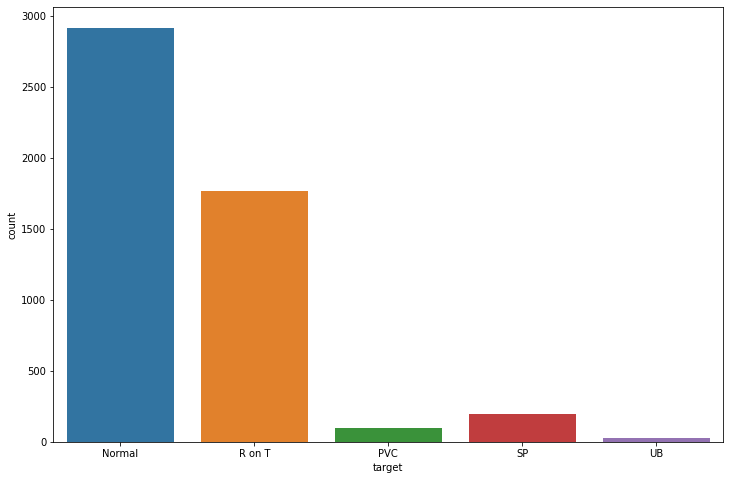

In [9]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x=df.target)
ax.set_xticklabels(class_names);

As we can see, classes are very unbalanced, with normal class being the most common with 2919 sequences, followed by the class with label R-on-T PVC. Moreover, if we sum all the remaining abnormal sequences we get a total value of 2081, which gets closer to the amount of normal sequences.

Now we plot an averaged time series for each class, smoothed out with a standard deviation around it:

In [10]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data) 
  
  # sliding window iterator rolling(win_size)
  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  # smooth with a std under and over the line
  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(path_deviation.index, under_line, over_line, alpha=.200)
  ax.set_title(class_name)

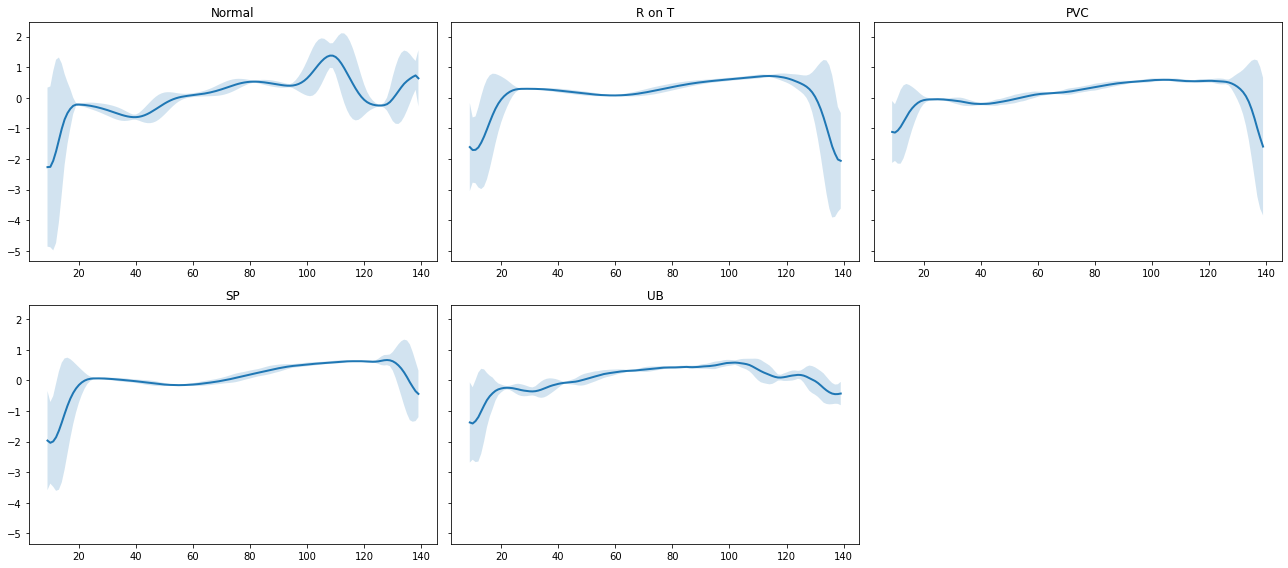

In [11]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(18, 8)
)

# plot for each class (1-5)
for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()    
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

We can notice how the normal class has a distinctly different pattern compared to all the other abnormal classes. The blue line indicates the overall average amplitude, surrounded by one standard deviation in both sides, depicted in light blue.

### Data Preprocessing

We now split the data into training, validation and test sets with the following proportion: 67% for the training set and the remaining 33% equally split between validation and test sets.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df.values,
                                                    df.values[:,-1], 
                                                    test_size=0.33,
                                                    random_state=RANDOM_SEED)

X_test, X_val, y_test, y_val = train_test_split(X_test,
                                                    y_test, 
                                                    test_size=0.5,
                                                    random_state=RANDOM_SEED)

In [13]:
print('The shape of the training set: ', X_train.shape)
print('The shape of the validation set:  ', X_val.shape)
print('The shape of the test set:  ', X_test.shape)

The shape of the training set:  (3350, 141)
The shape of the validation set:   (825, 141)
The shape of the test set:   (825, 141)


As normalization pre-processing technique, we apply MinMax scaler to the input signals in order to scale and translate them into a [0, 1] range, excluding the last target column.

In [14]:
scaler = MinMaxScaler()
data_scaled = scaler.fit(X_train[:,:-1])    

In [15]:
X_train[:,:-1] = data_scaled.transform(X_train[:,:-1])
X_val[:,:-1] = data_scaled.transform(X_val[:,:-1])
X_test[:,:-1] = data_scaled.transform(X_test[:,:-1])

We now prepare the data for training our model: we divide the signals into normal (if the class is equal to 1) and anomalous (if the class is > 1), each one with its training, validation and test set.

In [16]:
df_train = pd.DataFrame(X_train)
df_val = pd.DataFrame(X_val)
df_test = pd.DataFrame(X_test)

In [17]:
# Filters out normal signals (target = 1)
def filter_normal_signals(df):
  df = df[df.iloc[:,-1] == 1].drop(columns=df.columns[-1], axis=1)
  return df.values

# Filters out anomalous signals (target > 1)
def filter_anomalous_signals(df):
  df = df[df.iloc[:,-1] > 1].drop(columns=df.columns[-1], axis=1)
  return df.values

In [18]:
normal_X_train = filter_normal_signals(df_train)
normal_X_val = filter_normal_signals(df_val) 
normal_X_test = filter_normal_signals(df_test)

In [19]:
print('The shape of the normal signals training set: ', normal_X_train.shape)
print('The shape of the normal signals validation set:  ', normal_X_val.shape)
print('The shape of the normal signals test set:  ', normal_X_test.shape)

The shape of the normal signals training set:  (1932, 140)
The shape of the normal signals validation set:   (492, 140)
The shape of the normal signals test set:   (495, 140)


The same process is applied to the anomalous signals:

In [20]:
anomaly_X_train = filter_anomalous_signals(df_train)
anomaly_X_val = filter_anomalous_signals(df_val) 
anomaly_X_test = filter_anomalous_signals(df_test)

In [21]:
print('The shape of the normal signals training set: ', anomaly_X_train.shape)
print('The shape of the normal signals validation set:  ', anomaly_X_val.shape)
print('The shape of the normal signals test set:  ', anomaly_X_test.shape)

The shape of the normal signals training set:  (1418, 140)
The shape of the normal signals validation set:   (333, 140)
The shape of the normal signals test set:   (330, 140)


We plot five normal signals and five anomalous signals to compare them and find out the main variations.

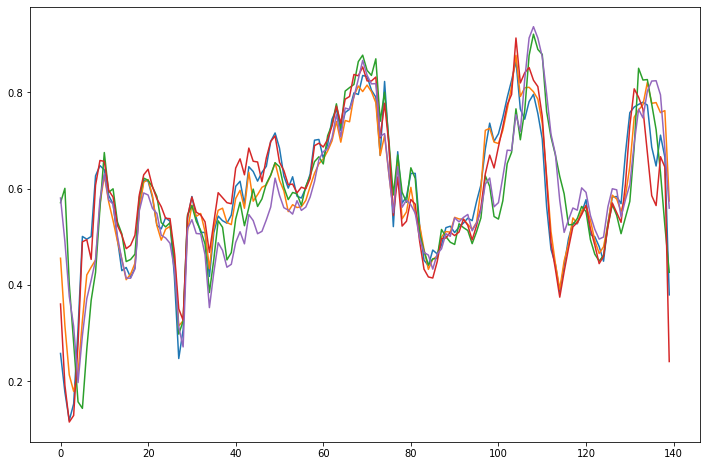

In [22]:
# normal signals

plt.figure(figsize=(12,8)) 
for i in range(5,10):
  plt.plot(normal_X_train[i])

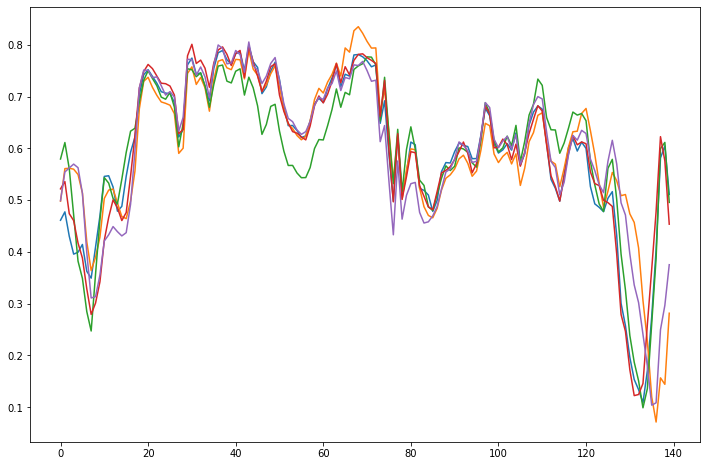

In [23]:
# anomalous signals

plt.figure(figsize=(12,8)) 
for i in range(5,10):
  plt.plot(anomaly_X_train[i])

These plots confirm the pattern seen before for the normal and anomalous signals.

## Autoencoder

Autoencoders are a type of neural network used for unsupervised learning, designed to reconstruct its input vector: the objective of an autoencoder is to obtain a reconstruction of the given input, minimizing its reconstruction error. The reconstruction should match the input as much as possible. Since autoencoders try to learn only the most important features, meaning the compressed version of the data, it is usually a good idea to use a small number of parameters.

We will train an autoencoder only on the normal ECG sequences, such that it reconstructs these examples with minimal error. The idea is the following: abnormal signals should have a higher reconstruction error compared to the normal sequences, allowing us to classify a signal as an anomaly if the reconstruction error is higher than a given threshold.

To reconstruct the input as best as possible we will need a reconstruction loss to minimize. In this case we will minimize the **MSE (Mean Squared Error)**, which is defined as the mean of the squared difference between the network's output and the ground truth: 

MSE = $\frac{1}{n} \Sigma_{i=1}^n({y}-\hat{y})^2$.

The autoencoder is made of dense layers and is trying to learn the distribution of the signal, in order to reproduce it as output. Since we are training it on the normal data it will learn to reproduce the normal data.

In [24]:
class AutoEncoder(Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    # Define the encoder 
    self.encoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    # Define the decoder 
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    # Define how an evaluation of the network is performed
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [25]:
autoencoder = AutoEncoder()

early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss', 
                    patience=5,
                    mode='min',
                    restore_best_weights=True)

lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,
    patience=5, 
    min_lr=1e-6, 
    mode='min')

autoencoder.compile(optimizer='adam', loss='mse')

In [26]:
history = autoencoder.fit(normal_X_train, normal_X_train, 
                    epochs=30,
                    batch_size=128,
                    validation_data=(normal_X_val, normal_X_val),
                    callbacks=[early_stopping, lr_plateau],
                    shuffle=True)

Epoch 1/30
16/16 [==============================] - 2s 34ms/step - loss: 0.0258 - val_loss: 0.0206 - lr: 0.0010
Epoch 2/30
16/16 [==============================] - 0s 8ms/step - loss: 0.0137 - val_loss: 0.0093 - lr: 0.0010
Epoch 3/30
16/16 [==============================] - 0s 9ms/step - loss: 0.0069 - val_loss: 0.0067 - lr: 0.0010
Epoch 4/30
16/16 [==============================] - 0s 18ms/step - loss: 0.0056 - val_loss: 0.0062 - lr: 0.0010
Epoch 5/30
16/16 [==============================] - 0s 8ms/step - loss: 0.0053 - val_loss: 0.0061 - lr: 0.0010
Epoch 6/30
16/16 [==============================] - 0s 9ms/step - loss: 0.0053 - val_loss: 0.0061 - lr: 0.0010
Epoch 7/30
16/16 [==============================] - 0s 8ms/step - loss: 0.0052 - val_loss: 0.0060 - lr: 0.0010
Epoch 8/30
16/16 [==============================] - 0s 8ms/step - loss: 0.0052 - val_loss: 0.0060 - lr: 0.0010
Epoch 9/30
16/16 [==============================] - 0s 8ms/step - loss: 0.0052 - val_loss: 0.0060 - lr: 0.0010

In [27]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16)                144       
                                                                 
 dense_5 (Dense)             (None, 32)                544       
                                                                 
 dense_6 (Dense)             (None, 64)                2112      
                                                                 
 dense_7 (Dense)             (None, 140)               9100      
                                                                 
Total params: 11,900
Trainable params: 11,900
Non-trainable params: 0
_________________________________________________________________


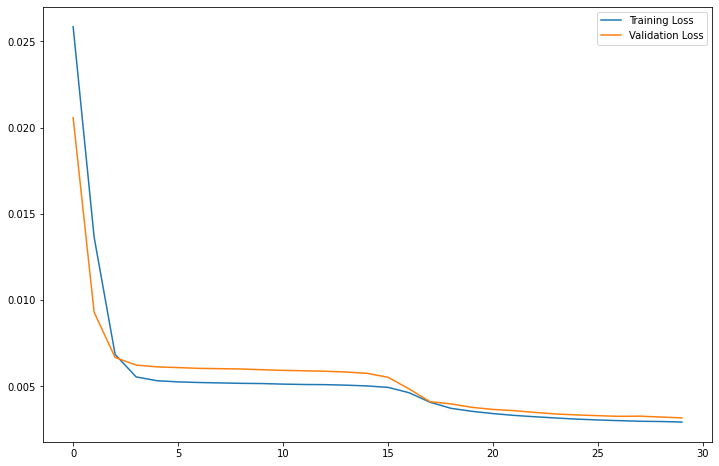

In [28]:
plt.figure(figsize=(12,8)) 
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

We now pass the normal test data into the model to obtain its decoded signal and plot the distribution of an example, comparing it with its original shape. The process is done also for the anomalous data.

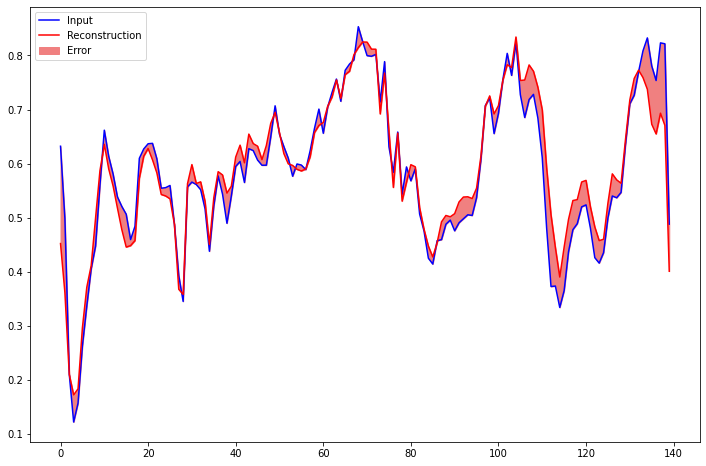

In [29]:
encoded_signal = autoencoder.encoder(normal_X_test).numpy()
decoded_signal = autoencoder.decoder(encoded_signal).numpy()

plt.figure(figsize=(12,8)) 
plt.plot(normal_X_test[0], 'b')
plt.plot(decoded_signal[0], 'r')
plt.fill_between(np.arange(140), decoded_signal[0], normal_X_test[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

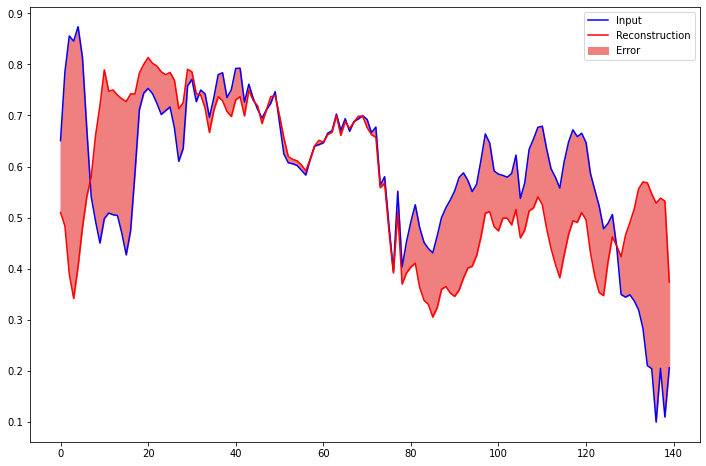

In [30]:
encoded_signal = autoencoder.encoder(anomaly_X_test).numpy()
decoded_signal = autoencoder.decoder(encoded_signal).numpy()

plt.figure(figsize=(12,8)) 
plt.plot(anomaly_X_test[0], 'b')
plt.plot(decoded_signal[0], 'r')
plt.fill_between(np.arange(140), decoded_signal[0], anomaly_X_test[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

As we can see, the normal signals are fit more accurately, since the autoencoder is able to reconstruct them with lower error, while the reconstructed abnormal signals produce a higher error.

### Choosing a threshold

We now compute the mean squared error (MSE) of the normal and abnormal training data, plotting their distribution and based on that we will choose the threshold.

In [31]:
reconstruction = autoencoder.predict(normal_X_train)
train_loss = tf.keras.losses.mse(reconstruction, normal_X_train) 

61/61 [==============================] - 0s 2ms/step


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Distribution of normal train data')]

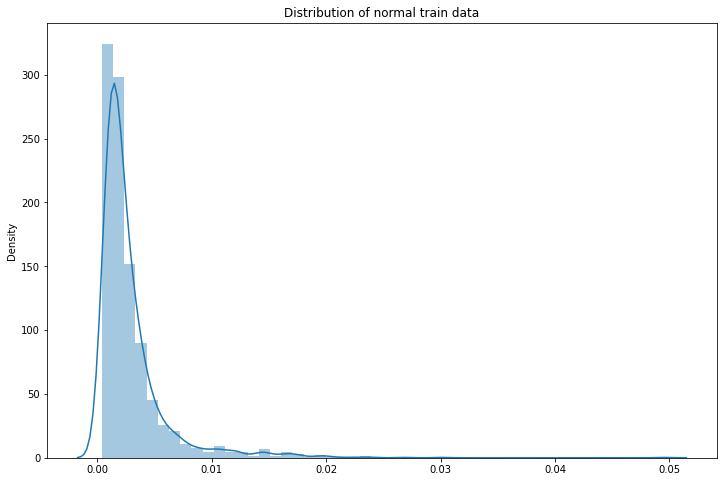

In [32]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(train_loss, bins=50, kde=True, ax=ax).set(title='Distribution of normal train data')

In order to set the threshold we decide to calculate the threshold dynamically based on the reconstruction error distribution of the normal samples. For example, the threshold can be given by the mean of the reconstruction error plus a multiple of the standard deviation. This allows the threshold to adapt to changes in the data distribution over time. In this case we compute the threshold value given by two standard deviations above the mean.

In [33]:
mean_normal = np.mean(train_loss)
std_normal = np.std(train_loss)

In [34]:
threshold = mean_normal + 2*std_normal
print("Threshold: ", threshold)

Threshold:  0.009288459050375295


### Evaluation

Using the computed threshold we can turn the problem into a binary classification task:
- if the reconstruction loss for an example is below the threshold, it will be classified as a normal heartbeat
- alteratively, if the loss is higher than the threshold, it will be classified as an anomaly

Evaluation on normal data: we now calculate the loss on the normal test data and plot the distribution histogram, then repeat the process for anomalous data.

In [35]:
reconstruction_test = autoencoder.predict(normal_X_test)
test_loss_normal = tf.keras.losses.mse(reconstruction_test, normal_X_test) 

16/16 [==============================] - 0s 7ms/step


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Distribution of normal test data')]

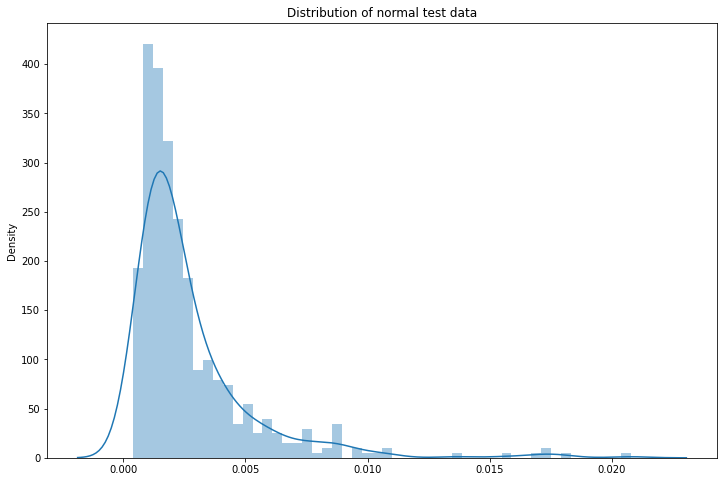

In [36]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(test_loss_normal, bins=50, kde=True, ax=ax).set(title='Distribution of normal test data')

Evaluation on anomalous data

In [37]:
reconstruction_anomalies = autoencoder.predict(anomaly_X_test)
test_loss_anomalies = tf.keras.losses.mse(reconstruction_anomalies, anomaly_X_test)

11/11 [==============================] - 0s 5ms/step


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Distribution of anomalous test data')]

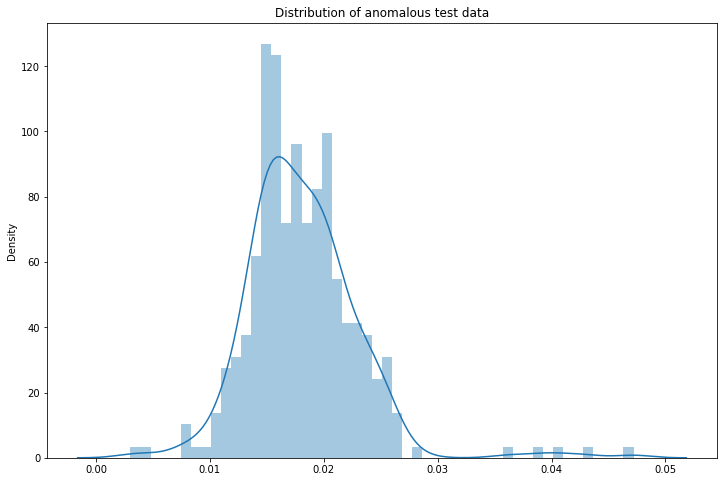

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(test_loss_anomalies, bins=50, kde=True, ax=ax).set(title='Distribution of anomalous test data')

We now combine the two things together by plotting both distributions and the threshold line:

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


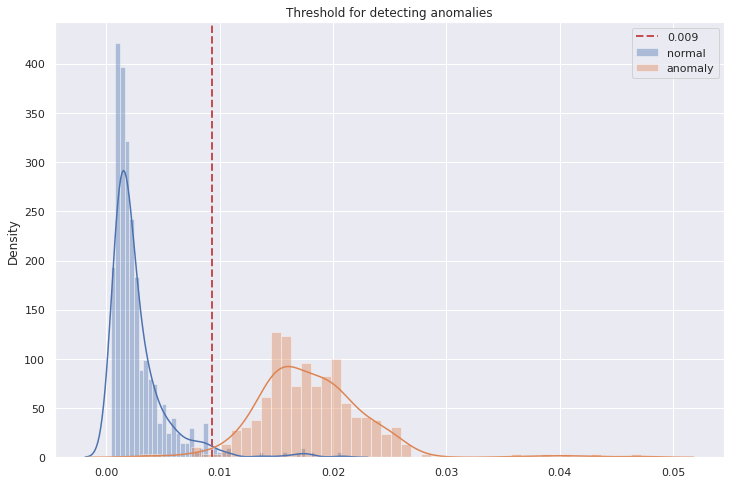

In [39]:
sns.set(rc={'figure.figsize':(12,8)})

# Plot two histograms of normal and anomalous data
sns.distplot(test_loss_normal.numpy(), bins=50, label='normal')
sns.distplot(test_loss_anomalies.numpy(), bins=50, label='anomaly')

# Plot a vertical line representing the threshold
plt.axvline(threshold, color='r', linewidth=2, linestyle='dashed', label='{:0.3f}'.format(threshold))

# Add legend and title
plt.legend(loc='upper right')
plt.title('Threshold for detecting anomalies')
plt.show()

As we can see, it seems that the threshold allows to distinguish well the anomalies from normal signals: by varing the threshold, we can adjust the precision and recall of the classifier.

### Confusion matrix and ROC curve

In order to plot the confusion matrix and ROC curve we first need to count the amount of false positives or false negatives: we compare the threshold with the test losses of normal and abnormal data and get an array of boolean values.

In [40]:
def predict_metrics(normal, anomalous, threshold):
    # We correctly detect normal data if the normal loss is smaller than the threshold
    pred_normal = tf.math.less(normal, threshold)
    
    # We correctly detect anomalous data if the normal loss is greater than the threshold
    pred_anomaly = tf.math.greater(anomalous, threshold)

    tn = tf.math.count_nonzero(pred_normal).numpy()
    fp = normal.shape[0] - tn

    tp = tf.math.count_nonzero(pred_anomaly).numpy()
    fn = anomalous.shape[0] - tp
    
    return tp, tn, fp, fn

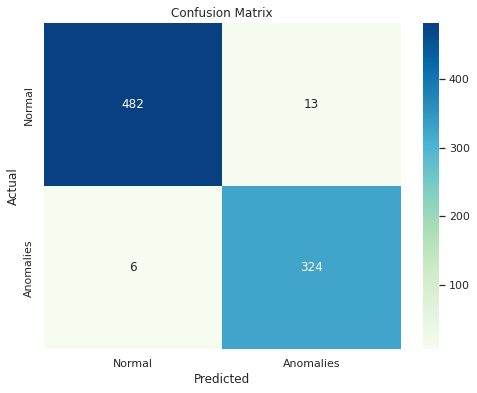

In [41]:
tp, tn, fp, fn = predict_metrics(test_loss_normal, test_loss_anomalies, threshold)

cm = [[tn, fp], 
      [fn, tp]]
categories = ['Normal', 'Anomalies']

plt.figure(figsize=(8,6))
g = sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=categories, 
            yticklabels=categories, 
            cmap="GnBu")

g.set(xlabel='Predicted', ylabel='Actual', title='Confusion Matrix')

plt.show()

Now we will predict True Positives (TP), True Negatives (TN), False Positives (FP) and False Negatives (FN) and plot the ROC-AUC curve.

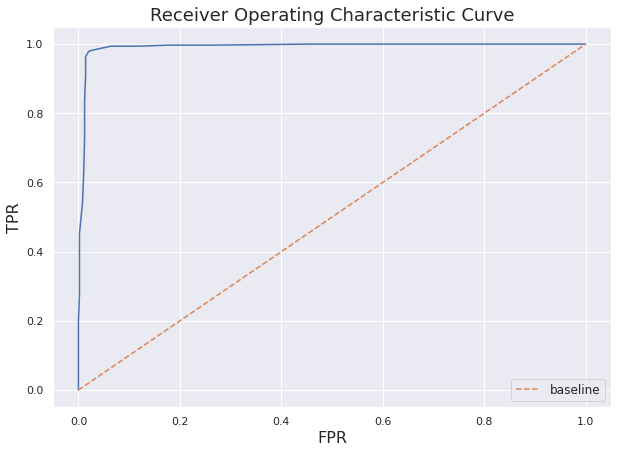

In [42]:
tpr_val = []
fpr_val = []

for t in np.linspace(0, 1, 100):
    tp, tn, fp, fn = predict_metrics(test_loss_normal, 
                                    test_loss_anomalies, 
                                    t/10)
    tpr = tp/(tp + fn)
    fpr = fp/(fp + tn)
    tpr_val.append(tpr)
    fpr_val.append(fpr)

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr_val, tpr_val)
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
plt.legend(fontsize=12);

Finally, we report the main results obtained by the model in terms of Accuracy, Precision, Recall and F1-Score.

In [43]:
def compute_stats(tp, tn, fp, fn):
  acc = (tp + tn) / (tp + tn + fp + fn)
  prec = tp / (tp + fp) 
  rec = tp / (tp + fn)
  f1 = 2 * (prec * rec) / (prec + rec)

  return acc, prec, rec, f1

In [44]:
tp, tn, fp, fn = predict_metrics(test_loss_normal, test_loss_anomalies, threshold)
accuracy, precision, recall, f1 = compute_stats(tp, tn, fp, fn)

print("Accuracy = {}".format(np.round(accuracy,4)))
print("Precision = {}".format(np.round(precision,4)))
print("Recall = {}".format(np.round(recall,4)))
print("F1-score = {}".format(np.round(f1,4)))

Accuracy = 0.977
Precision = 0.9614
Recall = 0.9818
F1-score = 0.9715


## LSTM Autoencoder

We now define a variation of the original autoencoder: a LSTM autoencoder. LSTMs are a type of recurrent neural network, which means they have a "memory" that allows them to remember information from previous time steps in a sequence. The use of LSTM layers in autoencoders makes them well suited for sequences of data like ECG signals because they can capture the temporal dependencies and preserve the sequential structure of the input data. As before, we separate the encoder from the decoder: the Encoder uses two LSTM layers to compress the time series data input, while the decoder contains two LSTM layers and an output layer that gives the final reconstruction. The RepeatVector layer acts as a bridge between the encoder and decoder modules: it serves to repeat the encoded representation of the input sequence so that the decoder has access to this information at each time step during the decoding process. It essentially allows the information from the encoder to be "propagated" to the decoder by repeating the encoded representation of the input multiple times, so that it can be used as a context for the decoder to generate the output sequence.

In [65]:
class LSTMAutoencoder(Model):
  def __init__(self):
    super(LSTMAutoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Reshape((normal_X_train.shape[1], 1)),
        layers.LSTM(128, input_shape=(normal_X_train.shape[1], 1), return_sequences=True),
        layers.LSTM(64, return_sequences=False),
    ])

    self.repeat_vector = layers.RepeatVector(normal_X_train.shape[1])

    self.decoder = tf.keras.Sequential([
        layers.LSTM(64, return_sequences=True),
        layers.LSTM(128, return_sequences=True),
        layers.TimeDistributed(layers.Dense(1)),
        layers.Reshape((normal_X_train.shape[1],))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    repeated = self.repeat_vector(encoded)
    decoded = self.decoder(repeated)
    return decoded

In [66]:
LSTMautoencoder = LSTMAutoencoder()

early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss', 
                    patience=5,
                    mode='min',
                    verbose=1,
                    restore_best_weights=True)

lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    verbose=1,
    mode='min')


In [67]:
LSTMautoencoder.compile(optimizer='adam', loss='mse')

history =  LSTMautoencoder.fit(normal_X_train, normal_X_train, 
                               epochs=20, 
                               validation_data=(normal_X_val, normal_X_val),
                               callbacks=[early_stopping, lr_plateau], 
                               shuffle=True)

Epoch 1/20
61/61 [==============================] - 44s 593ms/step - loss: 0.0379 - val_loss: 0.0189 - lr: 0.0010
Epoch 2/20
61/61 [==============================] - 34s 553ms/step - loss: 0.0179 - val_loss: 0.0184 - lr: 0.0010
Epoch 3/20
61/61 [==============================] - 34s 555ms/step - loss: 0.0176 - val_loss: 0.0182 - lr: 0.0010
Epoch 4/20
61/61 [==============================] - 33s 546ms/step - loss: 0.0174 - val_loss: 0.0179 - lr: 0.0010
Epoch 5/20
61/61 [==============================] - 33s 545ms/step - loss: 0.0169 - val_loss: 0.0174 - lr: 0.0010
Epoch 6/20
61/61 [==============================] - 35s 568ms/step - loss: 0.0160 - val_loss: 0.0161 - lr: 0.0010
Epoch 7/20
61/61 [==============================] - 33s 545ms/step - loss: 0.0151 - val_loss: 0.0178 - lr: 0.0010
Epoch 8/20
61/61 [==============================] - 33s 545ms/step - loss: 0.0168 - val_loss: 0.0171 - lr: 0.0010
Epoch 9/20
61/61 [==============================] - 33s 549ms/step - loss: 0.0158 - val_

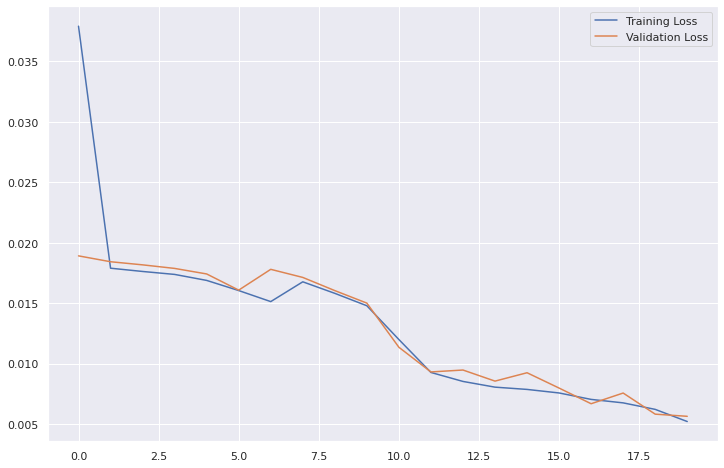

In [68]:
plt.figure(figsize=(12,8)) 
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

We now pass test data (normal and anomalous) into the model to obtain its decoded signal and plot the distribution of a signal example, comparing it with its original shape. 

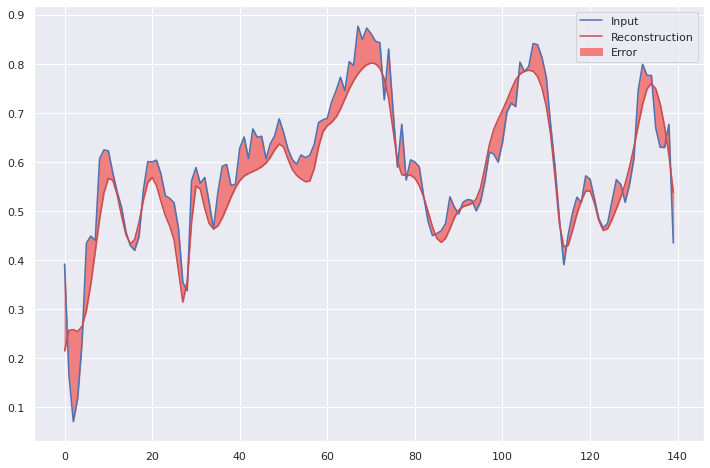

In [69]:
encoded_signal_lstm = LSTMautoencoder.encoder(normal_X_test).numpy()
repeated_signal_lstm = LSTMautoencoder.repeat_vector(encoded_signal_lstm).numpy()
decoded_signal_lstm = LSTMautoencoder.decoder(repeated_signal_lstm).numpy()

plt.figure(figsize=(12,8)) 
plt.plot(normal_X_test[100], 'b')
plt.plot(decoded_signal_lstm[100], 'r')
plt.fill_between(np.arange(140), decoded_signal_lstm[100], normal_X_test[100], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

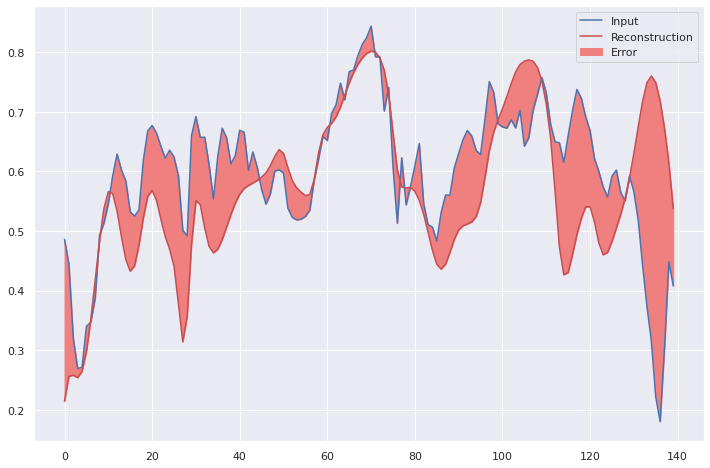

In [70]:
encoded_data_lstm = LSTMautoencoder.encoder(anomaly_X_test).numpy()
repeated_signal_lstm = LSTMautoencoder.repeat_vector(encoded_signal_lstm).numpy()
decoded_data_lstm = LSTMautoencoder.decoder(repeated_signal_lstm).numpy()

plt.figure(figsize=(12,8)) 
plt.plot(anomaly_X_test[100], 'b')
plt.plot(decoded_data_lstm[100], 'r')
plt.fill_between(np.arange(140), decoded_data_lstm[100], anomaly_X_test[100], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Again, we can see how the model is able to reconstruct better the normal signals with respect to the anomalous ones. We proceed with plotting the distribution of normal training data to choose the threshold, in the same way as before

In [71]:
reconstruction = LSTMautoencoder.predict(normal_X_train)
train_loss = tf.keras.losses.mse(reconstruction, normal_X_train) 

61/61 [==============================] - 11s 163ms/step


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Distribution of normal train data')]

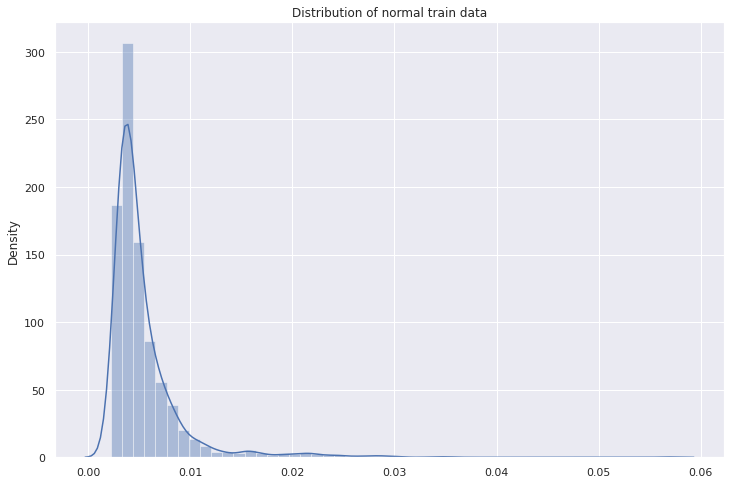

In [72]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(train_loss, bins=50, kde=True, ax=ax).set(title='Distribution of normal train data')

In [73]:
mean_normal = np.mean(train_loss)
std_normal = np.std(train_loss)

In [81]:
threshold = mean_normal + std_normal
print("Threshold: ", threshold)

Threshold:  0.009187512203882083


### Evaluation

We proceed with evaluation of both normal and anomalous data as before.

In [82]:
reconstruction_test = LSTMautoencoder.predict(normal_X_test)
test_loss_normal = tf.keras.losses.mse(reconstruction_test, normal_X_test) 

16/16 [==============================] - 3s 158ms/step


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Distribution of normal test data')]

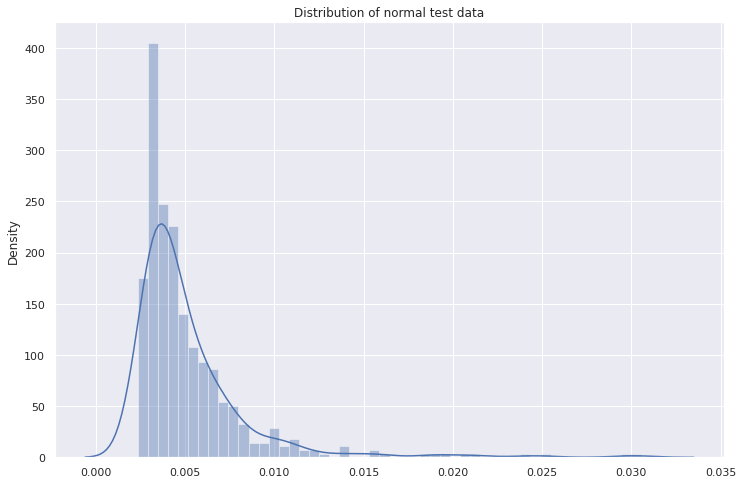

In [83]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(test_loss_normal, bins=50, kde=True, ax=ax).set(title='Distribution of normal test data')

Evaluation on anomalous data

In [84]:
reconstruction_anomalies = LSTMautoencoder.predict(anomaly_X_test)
test_loss_anomalies = tf.keras.losses.mse(reconstruction_anomalies, anomaly_X_test)

11/11 [==============================] - 2s 214ms/step


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Distribution of anomalous test data')]

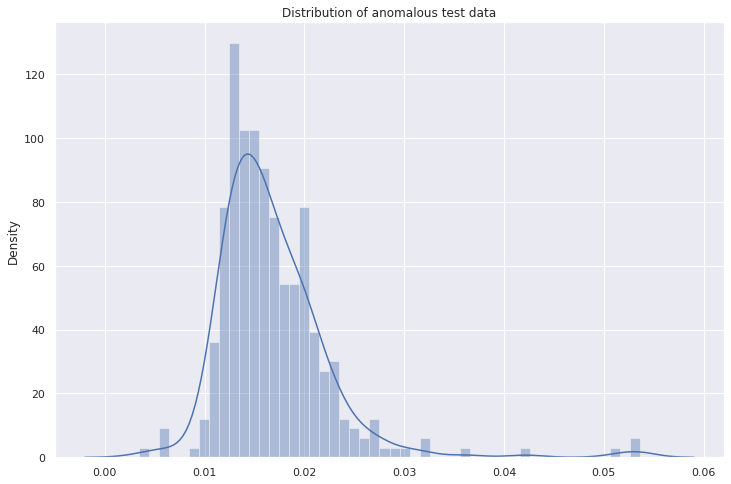

In [85]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(test_loss_anomalies, bins=50, kde=True, ax=ax).set(title='Distribution of anomalous test data')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


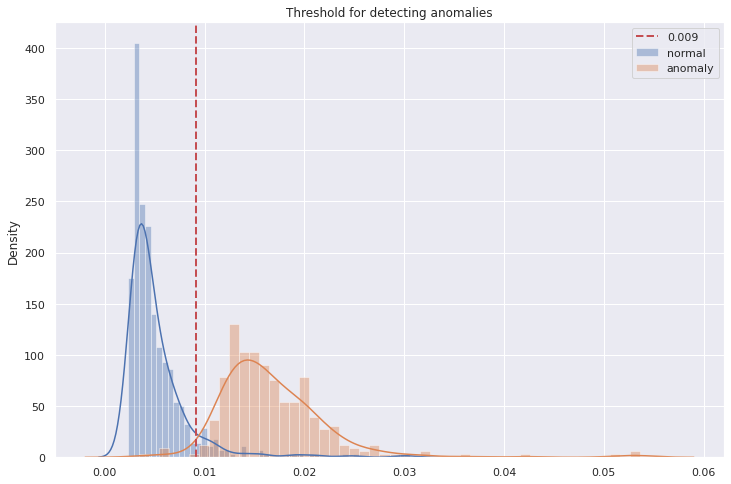

In [86]:
sns.set(rc={'figure.figsize':(12,8)})

# Plot two histograms of normal and anomalous data
sns.distplot(test_loss_normal.numpy(), bins=50, label='normal')
sns.distplot(test_loss_anomalies.numpy(), bins=50, label='anomaly')

# Plot a vertical line representing the threshold
plt.axvline(threshold, color='r', linewidth=2, linestyle='dashed', label='{:0.3f}'.format(threshold))

# Add legend and title
plt.legend(loc='upper right')
plt.title('Threshold for detecting anomalies')
plt.show()

Again, it seems that the threshold allows to distinguish the anomalies from normal signals: by varing the threshold, we can adjust the precision and recall of the classifier.

### Confusion matrix

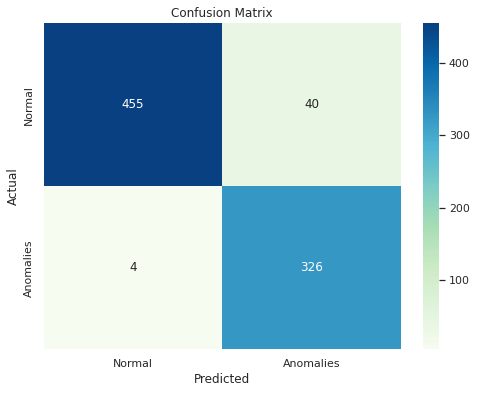

In [87]:
tp, tn, fp, fn = predict_metrics(test_loss_normal, test_loss_anomalies, threshold)

cm = [[tn, fp], 
      [fn, tp]]

categories = ['Normal', 'Anomalies']

plt.figure(figsize=(8,6))
g = sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=categories, 
            yticklabels=categories,
            cmap="GnBu")

g.set(xlabel='Predicted', ylabel='Actual', title='Confusion Matrix')

plt.show()

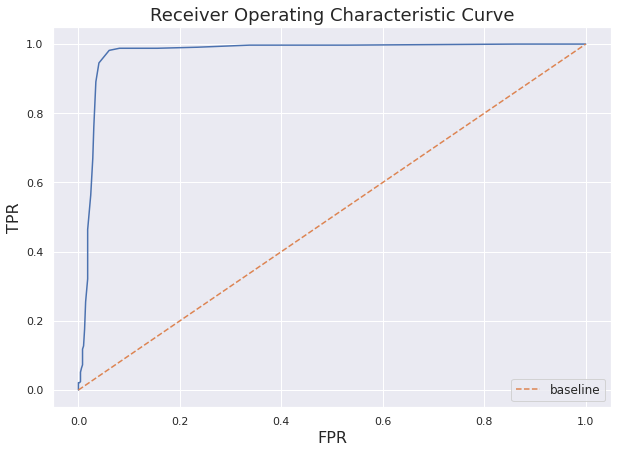

In [88]:
tpr_val = []
fpr_val = []

for t in np.linspace(0, 1, 100):
    tp,tn,fp,fn = predict_metrics(test_loss_normal, 
                                  test_loss_anomalies, 
                                  t/10)
    tpr = tp/(tp + fn)
    fpr = fp/(fp + tn)
    tpr_val.append(tpr)
    fpr_val.append(fpr)

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr_val, tpr_val)
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
plt.legend(fontsize=12);

Results obtained by the LSTM Autoencoder:

In [89]:
tp, tn, fp, fn = predict_metrics(test_loss_normal, test_loss_anomalies, threshold)
accuracy, precision, recall, f1 = compute_stats(tp, tn, fp, fn)

print("Accuracy = {}".format(np.round(accuracy,4)))
print("Precision = {}".format(np.round(precision,4)))
print("Recall = {}".format(np.round(recall,4)))
print("F1-score = {}".format(np.round(f1,4)))

Accuracy = 0.9467
Precision = 0.8907
Recall = 0.9879
F1-score = 0.9368


### Final remarks

By comparing the results obtained by the traditional Autoencoder and the LSTM Autoencoder, we see how similar they performed in distinguishing a normal ECG signal from an anomaly. Not only the model architecture itself is an important aspect to consider, but also the choice of the threshold, which indeed influences precision and recall of the model. Depending on the scenario and on what kind of errors we want to tolerate, it is possible to adjust the threshold. In this case, since we are dealing with ECG signals, it might be a better idea to get more false positives (normal heartbeats considered as anomalies) than false negatives (anomalies considered as normal).

### References

[1] Building Autoencoders in Keras, https://blog.keras.io/building-autoencoders-in-keras.html

[2] Learning Representations from Healthcare Time Series Data
for Unsupervised Anomaly Detection, Pereira & Silveira, 2019

[3] Robust Anomaly Detection in Time Series through Variational
AutoEncoders and a Local Similarity Score, Matias et al., 2021
